In [1]:
import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
# Importing SK-learn to calculate precision and recall
import sklearn
import sklearn.metrics

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K

tf.__version__

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'1.5.0'

In [2]:

#for i in {1,2,3,4,6,8,9}:
#    df1 = pd.read_pickle("./Pickles/processed_pck{}.pkl".format(i))
#    if(i == 1):
#        df = df1.copy()
#    else:
#        temp = [df,df1]
#        df = pd.concat(temp) 

#df.to_pickle('train_set.pkl')

In [3]:
train_set = pd.read_pickle('train_set.pkl')
train_set = train_set.sample(frac=1)
print(train_set.shape)

(261257, 6)


In [4]:
train_set.head()

,aray2,indx,x_actual,x_curr,y_actual,y_curr
4472,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19.0,356.0,329.0,1117.0,1107.0
44770,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",29.0,159.0,178.0,714.0,648.0
51975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 0, 0, 0, 0...",14.0,717.0,722.0,338.0,272.0
38275,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24.0,69.0,24.0,1683.0,1711.0
7595,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35.0,305.0,280.0,527.0,512.0


In [5]:
validation_set = pd.read_pickle('validation_set.pkl')
validation_set = validation_set.sample(frac=1)
print(validation_set.shape)

(79469, 6)


In [6]:
y_train = train_set[['x_curr', 'y_curr']].values
y_test = validation_set[['x_curr', 'y_curr']].values
mob_test = validation_set[['x_actual','y_actual']].values


In [7]:
img_rows, img_cols = 27, 15
x_train = []
[x_train.append(np.reshape(a,(img_rows,img_cols, 1))) for a in train_set.aray2]
x_train = np.asarray(x_train)
x_train = x_train.astype(np.float64)
x_train /= 255

x_test = []
[x_test.append(np.reshape(a,(img_rows,img_cols, 1))) for a in validation_set.aray2]
x_test = np.asarray(x_test)
x_test = x_test.astype(np.float64)
x_test /= 255

In [8]:
del train_set
del validation_set

In [9]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)
print(mob_test.shape)

(261257, 27, 15, 1)
(261257, 2)
(79469, 27, 15, 1)
(79469, 2)
(79469, 2)


[285. 457.]


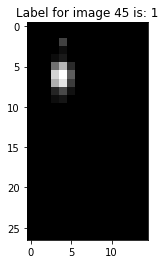

In [10]:
i = 45
plt.imshow(x_train[i].reshape(27, 15),cmap='gray') #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, np.argmax(y_train[i])))
print(y_train[i])

In [11]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [12]:

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
########## HYPER PARAMETERS
batch_size = 128
epochs = 1000
optimizer = tf.keras.optimizers.Adam(decay=0.001)
########## HYPER PARAMETERS

In [14]:
########## MODEL ARCHITECTURE
model = tf.keras.Sequential()

### OLD ARCHITECTURE START
#model.add(tf.keras.layers.Dense(5, activation='relu', input_shape=(784,)))
### OLD ARCHITECTURE END

### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3),
                                 activation='relu',
                                 #padding='same',
                                 input_shape=input_shape))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                       padding='same'))

model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3),
                                 activation='relu',
                                 padding='same'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                       padding='same'))

#model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3),
#                                 activation='relu',
#                                 padding='same'))

#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
#                                       padding='same'))
model.add(tf.keras.layers.Flatten())
### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.25, noise_shape=None, seed=None))

model.add(tf.keras.layers.Dense(2, activation=None))
########## MODEL ARCHITECTURE

# Print summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 13, 5)         50        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 7, 5)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 7, 5)          230       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 4, 5)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 140)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               18048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
__________

In [ ]:
# compile model for training
def distance(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(tf.abs(y_pred[:,0]-y_true[:,0]))+tf.square(tf.abs(y_pred[:,1]-y_true[:,1]))))


model.compile(loss=distance,
              optimizer=optimizer,
              metrics=['mae','acc'])

def testmodel(epoch, logs):
    pred_y = model.predict(
        x_test,
        batch_size=batch_size
    )
    true_y = y_test

    eX = np.abs(true_y[:,0] - pred_y[:,0]) 
    eY = np.abs(true_y[:,1] - pred_y[:,1])
    ListError = eX + eY
    ListErrorX = eX
    ListErrorY = eY

    diff_true = true_y[:,0] + true_y[:,1]
    diff_pred = pred_y[:,0] + pred_y[:,1]
    RMSE = np.sqrt(np.mean(np.square(np.subtract(diff_pred, diff_true))))
    RMSEX = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,0], true_y[:,0]))))
    RMSEY   = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,1], true_y[:,1]))))

    print ('\nRMSE: %.2f RMSE-X: %.2f RMSE-Y: %.2f e: %.2f E-X: %.2f E-Y: %.2f std: %.2f std-X: %.2f std-Y: %.2f' %(
              RMSE, RMSEX, RMSEY,
                ListError.mean(), ListErrorX.mean(), ListErrorY.mean(),
                ListError.std(), ListErrorX.std(), ListErrorY.std(),))

testcallback = tf.keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    shuffle=True,
                    callbacks=[testcallback])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 261257 samples, validate on 79469 samples
Epoch 1/1000
261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 275.9386 - mean_absolute_error: 175.9898 - acc: 0.8913
RMSE: 283.84 RMSE-X: 119.32 RMSE-Y: 225.32 e: 223.04 E-X: 80.36 E-Y: 142.68 std: 221.60 std-X: 88.21 std-Y: 174.40
261257/261257 [==============================]261257/261257 [==============================] - 24s 91us/step - loss: 275.9343 - mean_absolute_error: 175.9870 - acc: 0.8913 - val_loss: 178.8113 - val_mean_absolute_error: 111.5177 - val_acc: 0.9533

Epoch 2/1000
260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 180.1937 - mean_absolute_error: 113.5391 - acc: 0.9501
RMSE: 207.73 RMSE-X: 87.15 RMSE-Y: 175.21 e: 178.97 E-X: 61.20 E-Y: 117.77 std: 160.82 std-X: 62.06 std-Y: 129.72
261257/261257 [==========================


Epoch 16/1000
260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 136.5595 - mean_absolute_error: 85.9185 - acc: 0.9638
RMSE: 134.58 RMSE-X: 56.21 RMSE-Y: 114.93 e: 114.10 E-X: 39.71 E-Y: 74.39 std: 108.13 std-X: 39.79 std-Y: 87.61
261257/261257 [==============================]261257/261257 [==============================] - 22s 82us/step - loss: 136.5645 - mean_absolute_error: 85.9212 - acc: 0.9638 - val_loss: 91.4348 - val_mean_absolute_error: 57.0483 - val_acc: 0.9598

Epoch 17/1000
260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 136.4742 - mean_absolute_error: 85.8462 - acc: 0.9637
RMSE: 133.66 RMSE-X: 55.76 RMSE-Y: 114.21 e: 112.92 E-X: 39.27 E-Y: 73.65 std: 107.66 std-X: 39.58 std-Y: 87.29
261257/261257 [==============================]261257/261257 [==============================] - 22s 83us/step - loss: 136.4831 - mean_absolute_error: 85.8525 - acc: 0.9638 -

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 129.3581 - mean_absolute_error: 81.0232 - acc: 0.9655
RMSE: 127.17 RMSE-X: 50.40 RMSE-Y: 110.52 e: 103.57 E-X: 34.71 E-Y: 68.86 std: 104.36 std-X: 36.54 std-Y: 86.45
261257/261257 [==============================]261257/261257 [==============================] - 20s 75us/step - loss: 129.3503 - mean_absolute_error: 81.0172 - acc: 0.9655 - val_loss: 83.6460 - val_mean_absolute_error: 51.7855 - val_acc: 0.9636

Epoch 47/1000
261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 128.9400 - mean_absolute_error: 80.7418 - acc: 0.9656
RMSE: 127.40 RMSE-X: 50.61 RMSE-Y: 110.22 e: 103.44 E-X: 35.02 E-Y: 68.42 std: 104.26 std-X: 36.53 std-Y: 86.42
261257/261257 [==============================]261257/261257 [==============================] - 20s 76us/step - loss: 128.9419 - mean_absolute_error: 80.7430 - acc: 0.9656 - val_loss: 83.4

260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 126.7524 - mean_absolute_error: 79.2884 - acc: 0.9662
RMSE: 127.03 RMSE-X: 49.34 RMSE-Y: 110.37 e: 102.35 E-X: 34.05 E-Y: 68.30 std: 103.64 std-X: 35.70 std-Y: 86.70
261257/261257 [==============================]261257/261257 [==============================] - 22s 83us/step - loss: 126.7511 - mean_absolute_error: 79.2877 - acc: 0.9662 - val_loss: 82.8098 - val_mean_absolute_error: 51.1743 - val_acc: 0.9642

Epoch 77/1000
260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 126.4144 - mean_absolute_error: 79.0734 - acc: 0.9661
RMSE: 128.49 RMSE-X: 49.67 RMSE-Y: 111.28 e: 103.96 E-X: 34.45 E-Y: 69.51 std: 103.72 std-X: 35.78 std-Y: 86.90
261257/261257 [==============================]261257/261257 [==============================] - 22s 82us/step - loss: 126.4113 - mean_absolute_error: 79.0717 - acc: 0.9661 - val_loss: 84.1

261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 125.8830 - mean_absolute_error: 78.7516 - acc: 0.9671
RMSE: 125.89 RMSE-X: 48.45 RMSE-Y: 109.92 e: 100.65 E-X: 33.37 E-Y: 67.28 std: 103.44 std-X: 35.13 std-Y: 86.92
261257/261257 [==============================]261257/261257 [==============================] - 31s 118us/step - loss: 125.8837 - mean_absolute_error: 78.7521 - acc: 0.9671 - val_loss: 81.5061 - val_mean_absolute_error: 50.3251 - val_acc: 0.9645

Epoch 107/1000
261120/261257 [============================>.]261120/261257 [============================>.] - ETA: 0s - loss: 125.6211 - mean_absolute_error: 78.6221 - acc: 0.9667
RMSE: 124.68 RMSE-X: 48.32 RMSE-Y: 109.03 e: 99.31 E-X: 33.21 E-Y: 66.10 std: 103.29 std-X: 35.10 std-Y: 86.71
261257/261257 [==============================]261257/261257 [==============================] - 32s 124us/step - loss: 125.6262 - mean_absolute_error: 78.6251 - acc: 0.9667 - val_loss: 80

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 124.9625 - mean_absolute_error: 78.2136 - acc: 0.9673
RMSE: 125.13 RMSE-X: 47.92 RMSE-Y: 109.55 e: 99.52 E-X: 32.95 E-Y: 66.57 std: 103.27 std-X: 34.80 std-Y: 87.00
261257/261257 [==============================]261257/261257 [==============================] - 22s 83us/step - loss: 124.9690 - mean_absolute_error: 78.2170 - acc: 0.9673 - val_loss: 80.6403 - val_mean_absolute_error: 49.7593 - val_acc: 0.9656

Epoch 137/1000
261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 125.0265 - mean_absolute_error: 78.2251 - acc: 0.9673
RMSE: 126.13 RMSE-X: 48.04 RMSE-Y: 110.26 e: 100.58 E-X: 33.10 E-Y: 67.48 std: 103.38 std-X: 34.82 std-Y: 87.20
261257/261257 [==============================]261257/261257 [==============================] - 24s 92us/step - loss: 125.0286 - mean_absolute_error: 78.2263 - acc: 0.9673 - val_loss: 81.5

260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 124.4353 - mean_absolute_error: 77.8894 - acc: 0.9674
RMSE: 125.59 RMSE-X: 47.73 RMSE-Y: 110.07 e: 99.95 E-X: 32.86 E-Y: 67.09 std: 103.28 std-X: 34.62 std-Y: 87.26
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 124.4246 - mean_absolute_error: 77.8853 - acc: 0.9674 - val_loss: 81.0509 - val_mean_absolute_error: 49.9749 - val_acc: 0.9657

Epoch 167/1000
260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 124.4355 - mean_absolute_error: 77.9062 - acc: 0.9673
RMSE: 124.47 RMSE-X: 47.68 RMSE-Y: 109.08 e: 98.58 E-X: 32.81 E-Y: 65.77 std: 103.10 std-X: 34.59 std-Y: 87.02
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 124.4133 - mean_absolute_error: 77.8924 - acc: 0.9673 - val_loss: 79.87

260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 123.7325 - mean_absolute_error: 77.4434 - acc: 0.9678
RMSE: 125.61 RMSE-X: 47.36 RMSE-Y: 110.26 e: 99.72 E-X: 32.57 E-Y: 67.16 std: 103.31 std-X: 34.38 std-Y: 87.45
261257/261257 [==============================]261257/261257 [==============================] - 22s 84us/step - loss: 123.7356 - mean_absolute_error: 77.4453 - acc: 0.9678 - val_loss: 80.9373 - val_mean_absolute_error: 49.8619 - val_acc: 0.9662

Epoch 197/1000
260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 123.8067 - mean_absolute_error: 77.5153 - acc: 0.9677
RMSE: 126.12 RMSE-X: 47.47 RMSE-Y: 110.45 e: 100.22 E-X: 32.72 E-Y: 67.51 std: 103.26 std-X: 34.40 std-Y: 87.42
261257/261257 [==============================]261257/261257 [==============================] - 22s 84us/step - loss: 123.8209 - mean_absolute_error: 77.5252 - acc: 0.9676 - val_loss: 81.3

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 123.3272 - mean_absolute_error: 77.1867 - acc: 0.9678
RMSE: 124.89 RMSE-X: 47.28 RMSE-Y: 109.53 e: 98.84 E-X: 32.57 E-Y: 66.27 std: 102.98 std-X: 34.27 std-Y: 87.21
261257/261257 [==============================]261257/261257 [==============================] - 22s 86us/step - loss: 123.3210 - mean_absolute_error: 77.1826 - acc: 0.9678 - val_loss: 80.1550 - val_mean_absolute_error: 49.4210 - val_acc: 0.9666

Epoch 227/1000
260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 123.3015 - mean_absolute_error: 77.1773 - acc: 0.9682
RMSE: 124.34 RMSE-X: 47.27 RMSE-Y: 109.02 e: 98.11 E-X: 32.55 E-Y: 65.56 std: 102.93 std-X: 34.28 std-Y: 87.10
261257/261257 [==============================]261257/261257 [==============================] - 22s 86us/step - loss: 123.3002 - mean_absolute_error: 77.1769 - acc: 0.9682 - val_loss: 79.52

260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 123.0643 - mean_absolute_error: 77.0132 - acc: 0.9679
RMSE: 123.89 RMSE-X: 46.89 RMSE-Y: 108.97 e: 97.57 E-X: 32.20 E-Y: 65.37 std: 102.96 std-X: 34.08 std-Y: 87.19
261257/261257 [==============================]261257/261257 [==============================] - 25s 96us/step - loss: 123.0594 - mean_absolute_error: 77.0098 - acc: 0.9678 - val_loss: 79.1147 - val_mean_absolute_error: 48.7850 - val_acc: 0.9664

Epoch 257/1000
260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 123.0796 - mean_absolute_error: 77.0190 - acc: 0.9675
RMSE: 125.02 RMSE-X: 47.19 RMSE-Y: 109.59 e: 98.75 E-X: 32.55 E-Y: 66.20 std: 103.02 std-X: 34.17 std-Y: 87.33
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 123.0718 - mean_absolute_error: 77.0149 - acc: 0.9675 - val_loss: 80.07

260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 122.7392 - mean_absolute_error: 76.8243 - acc: 0.9681
RMSE: 125.28 RMSE-X: 47.05 RMSE-Y: 109.97 e: 99.09 E-X: 32.43 E-Y: 66.66 std: 103.08 std-X: 34.09 std-Y: 87.46
261257/261257 [==============================]261257/261257 [==============================] - 26s 98us/step - loss: 122.7463 - mean_absolute_error: 76.8306 - acc: 0.9681 - val_loss: 80.4087 - val_mean_absolute_error: 49.5459 - val_acc: 0.9664

Epoch 287/1000
261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 122.9649 - mean_absolute_error: 76.9220 - acc: 0.9681
RMSE: 123.98 RMSE-X: 46.83 RMSE-Y: 108.98 e: 97.54 E-X: 32.19 E-Y: 65.35 std: 102.92 std-X: 34.01 std-Y: 87.21
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 122.9644 - mean_absolute_error: 76.9218 - acc: 0.9682 - val_loss: 79.09

260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 122.2961 - mean_absolute_error: 76.5510 - acc: 0.9677
RMSE: 124.33 RMSE-X: 46.81 RMSE-Y: 109.32 e: 98.13 E-X: 32.22 E-Y: 65.90 std: 102.82 std-X: 33.96 std-Y: 87.22
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 122.3047 - mean_absolute_error: 76.5569 - acc: 0.9677 - val_loss: 79.6111 - val_mean_absolute_error: 49.0644 - val_acc: 0.9665

Epoch 317/1000
260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 122.3840 - mean_absolute_error: 76.6053 - acc: 0.9677
RMSE: 124.12 RMSE-X: 46.74 RMSE-Y: 109.24 e: 97.95 E-X: 32.14 E-Y: 65.81 std: 102.81 std-X: 33.93 std-Y: 87.20
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 122.3953 - mean_absolute_error: 76.6121 - acc: 0.9677 - val_loss: 79.46

261120/261257 [============================>.]261120/261257 [============================>.] - ETA: 0s - loss: 122.1793 - mean_absolute_error: 76.4679 - acc: 0.9678
RMSE: 123.12 RMSE-X: 46.64 RMSE-Y: 108.39 e: 96.67 E-X: 32.07 E-Y: 64.60 std: 102.67 std-X: 33.87 std-Y: 87.04
261257/261257 [==============================]261257/261257 [==============================] - 25s 98us/step - loss: 122.1842 - mean_absolute_error: 76.4710 - acc: 0.9678 - val_loss: 78.3569 - val_mean_absolute_error: 48.3343 - val_acc: 0.9665

Epoch 347/1000
261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 122.3102 - mean_absolute_error: 76.5630 - acc: 0.9685
RMSE: 124.14 RMSE-X: 46.69 RMSE-Y: 109.29 e: 97.92 E-X: 32.11 E-Y: 65.81 std: 102.82 std-X: 33.89 std-Y: 87.26
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 122.3131 - mean_absolute_error: 76.5645 - acc: 0.9685 - val_loss: 79.45

260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 122.2582 - mean_absolute_error: 76.5479 - acc: 0.9678
RMSE: 123.14 RMSE-X: 46.49 RMSE-Y: 108.56 e: 96.65 E-X: 31.94 E-Y: 64.71 std: 102.76 std-X: 33.78 std-Y: 87.17
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 122.2661 - mean_absolute_error: 76.5537 - acc: 0.9677 - val_loss: 78.3682 - val_mean_absolute_error: 48.3249 - val_acc: 0.9664

Epoch 377/1000
260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 122.0621 - mean_absolute_error: 76.4356 - acc: 0.9687
RMSE: 123.82 RMSE-X: 46.60 RMSE-Y: 108.99 e: 97.38 E-X: 32.07 E-Y: 65.31 std: 102.81 std-X: 33.81 std-Y: 87.26
261257/261257 [==============================]261257/261257 [==============================] - 26s 98us/step - loss: 122.0715 - mean_absolute_error: 76.4410 - acc: 0.9687 - val_loss: 78.97

260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 121.9500 - mean_absolute_error: 76.3487 - acc: 0.9684
RMSE: 122.87 RMSE-X: 46.37 RMSE-Y: 108.46 e: 96.36 E-X: 31.83 E-Y: 64.53 std: 102.77 std-X: 33.72 std-Y: 87.18
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 121.9347 - mean_absolute_error: 76.3395 - acc: 0.9684 - val_loss: 78.1374 - val_mean_absolute_error: 48.1776 - val_acc: 0.9665

Epoch 407/1000
260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 121.9573 - mean_absolute_error: 76.3264 - acc: 0.9684
RMSE: 123.27 RMSE-X: 46.47 RMSE-Y: 108.70 e: 96.86 E-X: 31.95 E-Y: 64.91 std: 102.73 std-X: 33.74 std-Y: 87.20
261257/261257 [==============================]261257/261257 [==============================] - 21s 80us/step - loss: 121.9569 - mean_absolute_error: 76.3259 - acc: 0.9684 - val_loss: 78.55

260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 121.7188 - mean_absolute_error: 76.2226 - acc: 0.9680
RMSE: 123.58 RMSE-X: 46.37 RMSE-Y: 108.94 e: 96.97 E-X: 31.88 E-Y: 65.10 std: 102.87 std-X: 33.67 std-Y: 87.35
261257/261257 [==============================]261257/261257 [==============================] - 26s 98us/step - loss: 121.7177 - mean_absolute_error: 76.2219 - acc: 0.9680 - val_loss: 78.6655 - val_mean_absolute_error: 48.4860 - val_acc: 0.9665

Epoch 437/1000
260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 121.7659 - mean_absolute_error: 76.2593 - acc: 0.9684
RMSE: 123.86 RMSE-X: 46.36 RMSE-Y: 109.28 e: 97.40 E-X: 31.86 E-Y: 65.53 std: 102.96 std-X: 33.67 std-Y: 87.45
261257/261257 [==============================]261257/261257 [==============================] - 26s 98us/step - loss: 121.7807 - mean_absolute_error: 76.2692 - acc: 0.9684 - val_loss: 79.04

260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 121.9229 - mean_absolute_error: 76.3566 - acc: 0.9681
RMSE: 123.11 RMSE-X: 46.24 RMSE-Y: 108.80 e: 96.58 E-X: 31.73 E-Y: 64.85 std: 102.88 std-X: 33.63 std-Y: 87.36
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 121.9365 - mean_absolute_error: 76.3626 - acc: 0.9681 - val_loss: 78.3586 - val_mean_absolute_error: 48.2895 - val_acc: 0.9665

Epoch 467/1000
260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 121.6738 - mean_absolute_error: 76.1800 - acc: 0.9684
RMSE: 123.89 RMSE-X: 46.42 RMSE-Y: 109.22 e: 97.40 E-X: 31.95 E-Y: 65.45 std: 102.90 std-X: 33.67 std-Y: 87.44
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 121.6715 - mean_absolute_error: 76.1782 - acc: 0.9684 - val_loss: 79.03

260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 121.8119 - mean_absolute_error: 76.2709 - acc: 0.9683
RMSE: 123.62 RMSE-X: 46.25 RMSE-Y: 109.20 e: 97.05 E-X: 31.79 E-Y: 65.26 std: 103.00 std-X: 33.60 std-Y: 87.55
261257/261257 [==============================]261257/261257 [==============================] - 20s 78us/step - loss: 121.8151 - mean_absolute_error: 76.2720 - acc: 0.9683 - val_loss: 78.7685 - val_mean_absolute_error: 48.5238 - val_acc: 0.9666

Epoch 497/1000
260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 121.7908 - mean_absolute_error: 76.2823 - acc: 0.9684
RMSE: 123.61 RMSE-X: 46.29 RMSE-Y: 109.06 e: 96.93 E-X: 31.84 E-Y: 65.09 std: 102.96 std-X: 33.60 std-Y: 87.50
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 121.7758 - mean_absolute_error: 76.2736 - acc: 0.9684 - val_loss: 78.64

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 121.5647 - mean_absolute_error: 76.1414 - acc: 0.9687
RMSE: 123.36 RMSE-X: 46.29 RMSE-Y: 108.96 e: 96.84 E-X: 31.85 E-Y: 64.99 std: 102.88 std-X: 33.60 std-Y: 87.46
261257/261257 [==============================]261257/261257 [==============================] - 26s 98us/step - loss: 121.5491 - mean_absolute_error: 76.1310 - acc: 0.9687 - val_loss: 78.5743 - val_mean_absolute_error: 48.4184 - val_acc: 0.9666

Epoch 527/1000
260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 121.4913 - mean_absolute_error: 76.0745 - acc: 0.9688
RMSE: 122.86 RMSE-X: 46.18 RMSE-Y: 108.73 e: 96.38 E-X: 31.71 E-Y: 64.67 std: 102.86 std-X: 33.57 std-Y: 87.41
261257/261257 [==============================]261257/261257 [==============================] - 25s 96us/step - loss: 121.5073 - mean_absolute_error: 76.0837 - acc: 0.9688 - val_loss: 78.20

261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 121.3900 - mean_absolute_error: 76.0286 - acc: 0.9687
RMSE: 123.01 RMSE-X: 46.17 RMSE-Y: 108.74 e: 96.37 E-X: 31.73 E-Y: 64.64 std: 102.88 std-X: 33.54 std-Y: 87.44
261257/261257 [==============================]261257/261257 [==============================] - 25s 98us/step - loss: 121.3906 - mean_absolute_error: 76.0290 - acc: 0.9687 - val_loss: 78.1847 - val_mean_absolute_error: 48.1830 - val_acc: 0.9665

Epoch 557/1000
261120/261257 [============================>.]261120/261257 [============================>.] - ETA: 0s - loss: 121.5633 - mean_absolute_error: 76.1087 - acc: 0.9684
RMSE: 123.74 RMSE-X: 46.19 RMSE-Y: 109.38 e: 97.26 E-X: 31.76 E-Y: 65.50 std: 102.99 std-X: 33.54 std-Y: 87.60
261257/261257 [==============================]261257/261257 [==============================] - 25s 96us/step - loss: 121.5656 - mean_absolute_error: 76.1100 - acc: 0.9684 - val_loss: 78.96

261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 121.3664 - mean_absolute_error: 75.9942 - acc: 0.9687
RMSE: 123.07 RMSE-X: 46.10 RMSE-Y: 108.83 e: 96.42 E-X: 31.68 E-Y: 64.74 std: 102.88 std-X: 33.49 std-Y: 87.48
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 121.3651 - mean_absolute_error: 75.9935 - acc: 0.9687 - val_loss: 78.2485 - val_mean_absolute_error: 48.2118 - val_acc: 0.9665

Epoch 587/1000
260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 121.5103 - mean_absolute_error: 76.0659 - acc: 0.9685
RMSE: 123.88 RMSE-X: 46.23 RMSE-Y: 109.33 e: 97.29 E-X: 31.83 E-Y: 65.46 std: 102.92 std-X: 33.52 std-Y: 87.57
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 121.5069 - mean_absolute_error: 76.0636 - acc: 0.9685 - val_loss: 78.97

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 121.2971 - mean_absolute_error: 75.9515 - acc: 0.9689
RMSE: 123.22 RMSE-X: 46.12 RMSE-Y: 108.95 e: 96.65 E-X: 31.73 E-Y: 64.92 std: 102.86 std-X: 33.48 std-Y: 87.50
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 121.2947 - mean_absolute_error: 75.9494 - acc: 0.9689 - val_loss: 78.4374 - val_mean_absolute_error: 48.3240 - val_acc: 0.9665

Epoch 617/1000
260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 121.3939 - mean_absolute_error: 76.0335 - acc: 0.9687
RMSE: 123.46 RMSE-X: 46.14 RMSE-Y: 109.15 e: 96.93 E-X: 31.74 E-Y: 65.18 std: 102.91 std-X: 33.49 std-Y: 87.56
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 121.3850 - mean_absolute_error: 76.0282 - acc: 0.9686 - val_loss: 78.67

261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 121.4076 - mean_absolute_error: 76.0212 - acc: 0.9686
RMSE: 123.36 RMSE-X: 46.15 RMSE-Y: 109.04 e: 96.77 E-X: 31.77 E-Y: 65.01 std: 102.89 std-X: 33.48 std-Y: 87.54
261257/261257 [==============================]261257/261257 [==============================] - 25s 96us/step - loss: 121.4072 - mean_absolute_error: 76.0210 - acc: 0.9686 - val_loss: 78.5435 - val_mean_absolute_error: 48.3872 - val_acc: 0.9665

Epoch 647/1000
260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 121.4990 - mean_absolute_error: 76.0842 - acc: 0.9685
RMSE: 122.98 RMSE-X: 46.02 RMSE-Y: 108.84 e: 96.32 E-X: 31.62 E-Y: 64.70 std: 102.90 std-X: 33.44 std-Y: 87.52
261257/261257 [==============================]261257/261257 [==============================] - 25s 97us/step - loss: 121.5064 - mean_absolute_error: 76.0887 - acc: 0.9685 - val_loss: 78.17

260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 121.2604 - mean_absolute_error: 75.9120 - acc: 0.9686
RMSE: 122.58 RMSE-X: 46.00 RMSE-Y: 108.55 e: 95.99 E-X: 31.61 E-Y: 64.38 std: 102.78 std-X: 33.42 std-Y: 87.40
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 121.2537 - mean_absolute_error: 75.9077 - acc: 0.9686 - val_loss: 77.8829 - val_mean_absolute_error: 47.9955 - val_acc: 0.9664

Epoch 677/1000
260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 121.1299 - mean_absolute_error: 75.8188 - acc: 0.9690
RMSE: 123.01 RMSE-X: 45.97 RMSE-Y: 109.05 e: 96.57 E-X: 31.57 E-Y: 65.00 std: 102.91 std-X: 33.42 std-Y: 87.55
261257/261257 [==============================]261257/261257 [==============================] - 21s 79us/step - loss: 121.1216 - mean_absolute_error: 75.8120 - acc: 0.9689 - val_loss: 78.41

260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 121.0848 - mean_absolute_error: 75.8111 - acc: 0.9691
RMSE: 122.41 RMSE-X: 45.98 RMSE-Y: 108.36 e: 95.70 E-X: 31.60 E-Y: 64.10 std: 102.76 std-X: 33.39 std-Y: 87.37
261257/261257 [==============================]261257/261257 [==============================] - 18s 71us/step - loss: 121.0720 - mean_absolute_error: 75.8021 - acc: 0.9691 - val_loss: 77.6267 - val_mean_absolute_error: 47.8492 - val_acc: 0.9664

Epoch 707/1000
260608/261257 [============================>.]260608/261257 [============================>.] - ETA: 0s - loss: 121.1123 - mean_absolute_error: 75.8513 - acc: 0.9685
RMSE: 122.50 RMSE-X: 45.94 RMSE-Y: 108.55 e: 95.88 E-X: 31.55 E-Y: 64.33 std: 102.82 std-X: 33.39 std-Y: 87.44
261257/261257 [==============================]261257/261257 [==============================] - 18s 71us/step - loss: 121.1202 - mean_absolute_error: 75.8571 - acc: 0.9685 - val_loss: 77.80

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 121.1437 - mean_absolute_error: 75.8442 - acc: 0.9691
RMSE: 123.07 RMSE-X: 45.94 RMSE-Y: 109.00 e: 96.51 E-X: 31.59 E-Y: 64.92 std: 102.86 std-X: 33.36 std-Y: 87.55
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 121.1476 - mean_absolute_error: 75.8471 - acc: 0.9692 - val_loss: 78.3528 - val_mean_absolute_error: 48.2556 - val_acc: 0.9663

Epoch 737/1000
261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 121.1323 - mean_absolute_error: 75.8342 - acc: 0.9687
RMSE: 123.02 RMSE-X: 46.02 RMSE-Y: 108.83 e: 96.36 E-X: 31.68 E-Y: 64.68 std: 102.83 std-X: 33.38 std-Y: 87.52
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 121.1315 - mean_absolute_error: 75.8338 - acc: 0.9687 - val_loss: 78.20

260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 121.3991 - mean_absolute_error: 76.0376 - acc: 0.9686
RMSE: 122.84 RMSE-X: 45.91 RMSE-Y: 108.83 e: 96.20 E-X: 31.57 E-Y: 64.64 std: 102.87 std-X: 33.34 std-Y: 87.56
261257/261257 [==============================]261257/261257 [==============================] - 18s 71us/step - loss: 121.3961 - mean_absolute_error: 76.0349 - acc: 0.9686 - val_loss: 78.0935 - val_mean_absolute_error: 48.1018 - val_acc: 0.9665

Epoch 767/1000
260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 121.1305 - mean_absolute_error: 75.8539 - acc: 0.9689
RMSE: 122.92 RMSE-X: 45.96 RMSE-Y: 108.79 e: 96.26 E-X: 31.63 E-Y: 64.63 std: 102.82 std-X: 33.35 std-Y: 87.52
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 121.1272 - mean_absolute_error: 75.8522 - acc: 0.9689 - val_loss: 78.12

260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 120.8372 - mean_absolute_error: 75.6431 - acc: 0.9692
RMSE: 122.95 RMSE-X: 45.90 RMSE-Y: 108.87 e: 96.30 E-X: 31.57 E-Y: 64.73 std: 102.83 std-X: 33.31 std-Y: 87.53
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.8535 - mean_absolute_error: 75.6529 - acc: 0.9692 - val_loss: 78.1757 - val_mean_absolute_error: 48.1520 - val_acc: 0.9664

Epoch 797/1000
260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 121.0755 - mean_absolute_error: 75.7931 - acc: 0.9690
RMSE: 122.70 RMSE-X: 45.88 RMSE-Y: 108.67 e: 96.02 E-X: 31.56 E-Y: 64.46 std: 102.80 std-X: 33.31 std-Y: 87.48
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 121.0647 - mean_absolute_error: 75.7851 - acc: 0.9690 - val_loss: 77.92

260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 120.8982 - mean_absolute_error: 75.6925 - acc: 0.9689
RMSE: 122.81 RMSE-X: 45.80 RMSE-Y: 108.88 e: 96.20 E-X: 31.49 E-Y: 64.72 std: 102.85 std-X: 33.26 std-Y: 87.56
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.8915 - mean_absolute_error: 75.6888 - acc: 0.9689 - val_loss: 78.1086 - val_mean_absolute_error: 48.1014 - val_acc: 0.9664

Epoch 827/1000
260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 121.0550 - mean_absolute_error: 75.7853 - acc: 0.9688
RMSE: 122.26 RMSE-X: 45.75 RMSE-Y: 108.45 e: 95.56 E-X: 31.43 E-Y: 64.13 std: 102.78 std-X: 33.25 std-Y: 87.45
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 121.0424 - mean_absolute_error: 75.7780 - acc: 0.9688 - val_loss: 77.55

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 120.8158 - mean_absolute_error: 75.6444 - acc: 0.9690
RMSE: 122.31 RMSE-X: 45.75 RMSE-Y: 108.48 e: 95.61 E-X: 31.44 E-Y: 64.18 std: 102.77 std-X: 33.24 std-Y: 87.46
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.8132 - mean_absolute_error: 75.6430 - acc: 0.9690 - val_loss: 77.6023 - val_mean_absolute_error: 47.8074 - val_acc: 0.9663

Epoch 857/1000
260864/261257 [============================>.]260864/261257 [============================>.] - ETA: 0s - loss: 120.5975 - mean_absolute_error: 75.4971 - acc: 0.9689
RMSE: 122.48 RMSE-X: 45.76 RMSE-Y: 108.59 e: 95.79 E-X: 31.46 E-Y: 64.33 std: 102.78 std-X: 33.23 std-Y: 87.48
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.5986 - mean_absolute_error: 75.4980 - acc: 0.9689 - val_loss: 77.74

261248/261257 [============================>.]261248/261257 [============================>.] - ETA: 0s - loss: 120.9069 - mean_absolute_error: 75.7203 - acc: 0.9691
RMSE: 122.19 RMSE-X: 45.69 RMSE-Y: 108.39 e: 95.46 E-X: 31.41 E-Y: 64.05 std: 102.72 std-X: 33.17 std-Y: 87.44
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.9090 - mean_absolute_error: 75.7218 - acc: 0.9691 - val_loss: 77.4691 - val_mean_absolute_error: 47.7316 - val_acc: 0.9663

Epoch 887/1000
261120/261257 [============================>.]261120/261257 [============================>.] - ETA: 0s - loss: 120.5776 - mean_absolute_error: 75.4680 - acc: 0.9691
RMSE: 122.42 RMSE-X: 45.69 RMSE-Y: 108.65 e: 95.82 E-X: 31.41 E-Y: 64.41 std: 102.77 std-X: 33.18 std-Y: 87.50
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.5853 - mean_absolute_error: 75.4725 - acc: 0.9691 - val_loss: 77.78

260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 120.5307 - mean_absolute_error: 75.4569 - acc: 0.9688
RMSE: 122.03 RMSE-X: 45.66 RMSE-Y: 108.38 e: 95.39 E-X: 31.40 E-Y: 63.99 std: 102.71 std-X: 33.14 std-Y: 87.47
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.5164 - mean_absolute_error: 75.4482 - acc: 0.9688 - val_loss: 77.4150 - val_mean_absolute_error: 47.6932 - val_acc: 0.9664

Epoch 917/1000
260480/261257 [============================>.]260480/261257 [============================>.] - ETA: 0s - loss: 121.0591 - mean_absolute_error: 75.8001 - acc: 0.9689
RMSE: 122.12 RMSE-X: 45.67 RMSE-Y: 108.37 e: 95.41 E-X: 31.42 E-Y: 63.98 std: 102.70 std-X: 33.14 std-Y: 87.46
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 121.0677 - mean_absolute_error: 75.8033 - acc: 0.9689 - val_loss: 77.42

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 120.5476 - mean_absolute_error: 75.4706 - acc: 0.9686
RMSE: 122.14 RMSE-X: 45.55 RMSE-Y: 108.53 e: 95.43 E-X: 31.29 E-Y: 64.13 std: 102.79 std-X: 33.10 std-Y: 87.56
261257/261257 [==============================]261257/261257 [==============================] - 18s 71us/step - loss: 120.5419 - mean_absolute_error: 75.4665 - acc: 0.9685 - val_loss: 77.4769 - val_mean_absolute_error: 47.7133 - val_acc: 0.9665

Epoch 947/1000
260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 120.3810 - mean_absolute_error: 75.3714 - acc: 0.9688
RMSE: 122.29 RMSE-X: 45.58 RMSE-Y: 108.63 e: 95.62 E-X: 31.34 E-Y: 64.29 std: 102.78 std-X: 33.11 std-Y: 87.57
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.3658 - mean_absolute_error: 75.3632 - acc: 0.9688 - val_loss: 77.64

260736/261257 [============================>.]260736/261257 [============================>.] - ETA: 0s - loss: 120.4524 - mean_absolute_error: 75.4086 - acc: 0.9681
RMSE: 122.12 RMSE-X: 45.58 RMSE-Y: 108.50 e: 95.44 E-X: 31.33 E-Y: 64.11 std: 102.74 std-X: 33.10 std-Y: 87.53
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.4463 - mean_absolute_error: 75.4060 - acc: 0.9681 - val_loss: 77.4872 - val_mean_absolute_error: 47.7197 - val_acc: 0.9665

Epoch 977/1000
260992/261257 [============================>.]260992/261257 [============================>.] - ETA: 0s - loss: 120.3494 - mean_absolute_error: 75.3741 - acc: 0.9686
RMSE: 122.16 RMSE-X: 45.57 RMSE-Y: 108.55 e: 95.53 E-X: 31.32 E-Y: 64.21 std: 102.73 std-X: 33.10 std-Y: 87.52
261257/261257 [==============================]261257/261257 [==============================] - 18s 70us/step - loss: 120.3491 - mean_absolute_error: 75.3744 - acc: 0.9686 - val_loss: 77.56

In [16]:
predict = model.predict(x_test)

In [20]:
def dist(y_pred,y_true):
    return np.mean(np.sqrt(np.square(np.abs(y_pred[:,0] - y_true[:,0]))+ np.square(np.abs(y_pred[:,1] - y_true[:,1]))))
print(predict[0])
print(y_test[0])
print(mob_test[0])
predict = predict.astype(np.float64)
model_error = (dist(y_test,predict))
mobile_error = dist(y_test,mob_test)
print(model_error)
print(mobile_error)


[192.01203918 454.58175659]
[231. 467.]
[218. 505.]
78.28840616662785
50.676487295081365


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [ ]:
# save model
model.save("myModel.h5")

# OLD MODEL:

In [ ]:
ä

In [ ]:
########## HYPER PARAMETERS
batch_size = 128
epochs = 20
optimizer = tf.keras.optimizers.Adam(decay=0.001)
########## HYPER PARAMETERS

########## MODEL ARCHITECTURE
model = tf.keras.Sequential()

### OLD ARCHITECTURE START
#model.add(tf.keras.layers.Dense(5, activation='relu', input_shape=(784,)))
### OLD ARCHITECTURE END

### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Conv2D(5, kernel_size=(7, 7), activation='relu', padding='same',input_shape=(27,15,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same', data_format=None))
model.add(tf.keras.layers.Conv2D(5, kernel_size=(5, 5), activation='relu', padding='same',input_shape=(27,15,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same', data_format=None))
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(27,15,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same', data_format=None))
model.add(tf.keras.layers.Flatten())
### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.25, noise_shape=None, seed=None))

model.add(tf.keras.layers.Dense(2, activation=None))
########## MODEL ARCHITECTURE

# Print summary
model.summary()

# compile model for training
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae','acc'])

history = model.fit(x_train, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,shuffle=True)